In [ ]:
"""\
This script contains all the functions used to generate average read counts by distance and fill fraction by distance plots in the paper "Dynamics of microcompartment formation at the mitosis-to-G1 transition".

Author: Viraat Goel
"""

# Part 1: Contact diagonal fill fraction plot

In [ ]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.0'):
    raise AssertionError("tutorials rely on cooltools version 0.5.0 or higher,"+
                         "please check your cooltools version and update to the latest")

In [46]:
resolution = 250 # input the desired data resolution
distances = [1000,2500,5000,10000,25000,50000,100000,250000,500000,1000000] # input the desired contact distance diagonal in bp

regionsRCMC = ['chr2:151920000-153000000','chr8:122950000-124110000','chr9:106675000-108600000','chr8:84846629-85856629','chr15:61810000-63684000']

# Load in each of the datasets at the specified resolution
clrRCMC_PM = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_AT = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_EG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_MG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_LG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_Asyn = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))

clrHiC_PM = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_AT = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_EG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_MG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_LG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))

# Variables for storing fill fraction data
countsAcrossDistances = [] # Stores the fraction of all non-empty bins for each dataset (across all regions) for each of the specified contact distances
nonZeroFracsByRegionAcrossDistances = [] # Stores the fraction of all non-empty bins for each dataset (region-separated) for each of the specified contact distances

for distance in distances:
    compiledCounts = [] # Stores the total number of bins and number of non-empty bins for each region of each dataset at the given contact distance

    coolers = [clrRCMC_PM,clrRCMC_AT,clrRCMC_EG1,clrRCMC_MG1,clrRCMC_LG1,clrRCMC_Asyn,clrHiC_PM,clrHiC_AT,clrHiC_EG1,clrHiC_MG1, clrHiC_LG1]
    coolerIt = 0 # An iterating variable for going through each of the datasets
    while coolerIt < len(coolers):
        regions = regionsRCMC # Use the RCMC regions for calculation

        totBins = [] # Counts the number of total contact bins for at the given contact distance
        nonZeroBins = [] # Counts the number of contact bins that have at least one read in them at the given contact distance

        for i in regions:        
            # Iterating region by region for the given dataset, load in the contact matrix
            # Keep balancing off to count raw read counts
            regionMat = coolers[coolerIt].matrix(balance=False).fetch(i)

            bins = len(regionMat) # Get the number of genomic bins across the matrix
            offset = distance // resolution - 1 # Calculate the number of fewer genomic bins at the given contact distance
            binsAtDiag = bins - offset # Calculate the total number of contact bins at the contact distance
            totBins.append(binsAtDiag)

            # Set the stage for iterating across the contact diagonal at the given distance to count the number of empty bins
            x = offset
            y = 0
            nonZeroCount = 0
            while x < len(regionMat):
                val = regionMat[y][x]
                if val > 0:
                    nonZeroCount += 1
                x += 1
                y += 1
            nonZeroBins.append(nonZeroCount)

        binCounts = [totBins,nonZeroBins] # Combine the total bin & non-empty bin counts into a tuple
        compiledCounts.append(binCounts) # Add the combined tuple for the given dataset & region to compiledCounts

        coolerIt += 1 # Onwards to the next cooler in the dataset list

    # print(compiledCounts) # Sanity check that the code is working 

    totNonZeroFrac = [] # Stores the across-regions fraction of non-empty bins for each dataset at a given contact distance
    nonZeroFracsByRegion = [] # The region-separated version of totNonZeroFrac

    # Iterate through compiledCounts to extract filled bin fractions
    for i in compiledCounts:
        sumPossible = sum(i[0]) # Sums the total number of bins across all regions for a dataset
        sumNonZero = sum(i[1]) # Sums the total number of non-empty bins across all regions for a dataset
        totNonZeroFrac.append(sumNonZero / sumPossible) # Adds the non-empty bin fraction to totNonZeroFrac

        coolerFracs = [] # An array to hold the non-empty bin fraction by region for a given dataset
        for j in range(len(i[0])): # Iterate across the regions
            fracNonZero = i[1][j] / i[0][j] # Calculate non-empty bin fraction for the given region
            coolerFracs.append(fracNonZero) # Add the calculated fraction to coolerFracs
        nonZeroFracsByRegion.append(coolerFracs) # Add the array of non-empty bin fractions by region to nonZeroFracsByRegion

    # print(totNonZeroFrac)
    # print(nonZeroFracsByRegion)
    
    nonZeroFracsByRegionAcrossDistances.append(nonZeroFracsByRegion) # Add nonZeroFracsByRegion, which contains the region-separated non-zero bin fraction for each dataset at the given contact distance, to nonZeroFracsByRegionAcrossDistances
    countsAcrossDistances.append(totNonZeroFrac) # Add totNonZeroFrac, which contains the non-zero bin fraction for each dataset at the given contact distance, to countsAcrossDistances
    
# countsAcrossDistances # Print the output of countsAcrossDistances to confirm that it produces a logical result

In [48]:
# Separate the nested array of countsAcrossDistance by dataset for ease of calculation & plotting
clrRCMC_PM_counts = []
clrRCMC_AT_counts = []
clrRCMC_EG1_counts = []
clrRCMC_MG1_counts = []
clrRCMC_LG1_counts = []
clrRCMC_Asyn_counts = []

clrHiC_PM_counts = []
clrHiC_AT_counts = []
clrHiC_EG1_counts = []
clrHiC_MG1_counts = []
clrHiC_LG1_counts = []

for i in countsAcrossDistances:
    clrRCMC_PM_counts.append(i[0])
    clrRCMC_AT_counts.append(i[1])
    clrRCMC_EG1_counts.append(i[2])
    clrRCMC_MG1_counts.append(i[3])
    clrRCMC_LG1_counts.append(i[4])
    clrRCMC_Asyn_counts.append(i[5])

    clrHiC_PM_counts.append(i[6])
    clrHiC_AT_counts.append(i[7])
    clrHiC_EG1_counts.append(i[8])
    clrHiC_MG1_counts.append(i[9])
    clrHiC_LG1_counts.append(i[10])

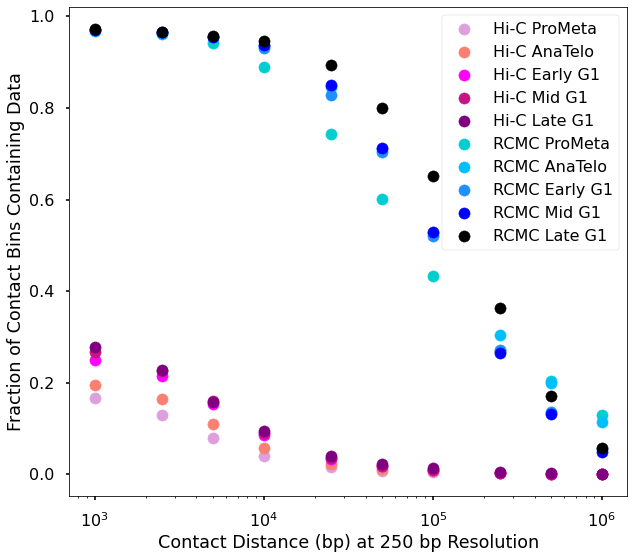

In [66]:
# Plot the fraction of filled bins across contact distances averaged across regions

import matplotlib.pyplot as plt

plt.figure(figsize=(10,9))

plt.scatter(distances, clrHiC_PM_counts, c = 'plum', label='Hi-C ProMeta')
plt.scatter(distances, clrHiC_AT_counts, c = 'salmon', label='Hi-C AnaTelo')
plt.scatter(distances, clrHiC_EG1_counts, c = 'magenta', label='Hi-C Early G1')
plt.scatter(distances, clrHiC_MG1_counts, c = 'mediumvioletred', label='Hi-C Mid G1')
plt.scatter(distances, clrHiC_LG1_counts, c = 'purple', label='Hi-C Late G1')
plt.scatter(distances, clrRCMC_PM_counts, c = 'darkturquoise', label='RCMC ProMeta')
plt.scatter(distances, clrRCMC_AT_counts, c = 'deepskyblue', label='RCMC AnaTelo')
plt.scatter(distances, clrRCMC_EG1_counts, c = 'dodgerblue', label='RCMC Early G1')
plt.scatter(distances, clrRCMC_MG1_counts, c = 'blue', label='RCMC Mid G1')
plt.scatter(distances, clrRCMC_LG1_counts, c = 'black', label='RCMC Late G1')

plt.xscale("log")
plt.xlabel("Contact Distance (bp) at 250 bp Resolution")
plt.ylabel("Fraction of Contact Bins Containing Data")
plt.legend()

plt.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200) # swap out .svg for the desired output file format
plt.show()

# Part 2: Contact diagonal average read count by distance plot

In [ ]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.0'):
    raise AssertionError("tutorials rely on cooltools version 0.5.0 or higher,"+
                         "please check your cooltools version and update to the latest")

##### This calculation is stylistically very similar to the calculation from Part 1, just modified to track the average number of reads at each contact distance; the code is presented here without detailed comments to avoid redundancy

In [3]:
resolution = 250 # input the desired data resolution
distances = [1000,2500,5000,10000,25000,50000,100000,250000,500000,1000000] # input the desired contact distance diagonal in bp

regionsRCMC = ['chr2:151920000-153000000','chr8:122950000-124110000','chr9:106675000-108600000','chr8:84846629-85856629','chr15:61810000-63684000']

# Load in each of the datasets at the specified resolution
clrRCMC_PM = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_AT = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_EG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_MG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_LG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_Asyn = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))

clrHiC_PM = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_AT = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_EG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_MG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrHiC_LG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))

coolers = [clrRCMC_PM,clrRCMC_AT,clrRCMC_EG1,clrRCMC_MG1,clrRCMC_LG1,clrRCMC_Asyn,clrHiC_PM,clrHiC_AT,clrHiC_EG1,clrHiC_LG1]

countsAcrossDistances = []
nonZeroFracsByRegionAcrossDistances = []
avgReadsAcrossDistances = []
avgReadsByRegionAcrossDistances = []

for distance in distances:
    compiledCounts = []

    coolerIt = 0
    while coolerIt < len(coolers):
        regions = regionsRCMC

        totBins = []
        nonZeroBins = []
        readCountsAcrossDiags = []

        for i in regions:        
            regionMat = coolers[coolerIt].matrix(balance=False).fetch(i)

            bins = len(regionMat)
            offset = distance // resolution - 1
            binsAtDiag = bins - offset
            totBins.append(binsAtDiag)

            x = offset
            y = 0
            nonZeroCount = 0
            readCountsAcrossDiag = []
            while x < len(regionMat):
                val = regionMat[y][x]
                if val > 0:
                    nonZeroCount += 1
                    readCountsAcrossDiag.append(val)
                x += 1
                y += 1
            nonZeroBins.append(nonZeroCount)
            readCountsAcrossDiags.append(sum(readCountsAcrossDiag))

        binCounts = [totBins,nonZeroBins,readCountsAcrossDiags]
        compiledCounts.append(binCounts)

        coolerIt += 1

    # print(compiledCounts)

    totNonZeroFrac = []
    nonZeroFracsByRegion = []
    avgReadsPerDist = []
    avgReadsPerDistByRegion = []

    for i in compiledCounts:
        sumPossible = sum(i[0])
        sumNonZero = sum(i[1])
        sumReadCounts = sum(i[2])
        
        totNonZeroFrac.append(sumNonZero / sumPossible)
        avgReadsPerDist.append(sumReadCounts / sumPossible)

        coolerFracs = []
        coolerAvgs = []
        for j in range(len(i[0])):
            fracNonZero = i[1][j] / i[0][j]
            coolerFracs.append(fracNonZero)
            
            avgReads = i[2][j] / i[0][j]
            coolerAvgs.append(avgReads)
        nonZeroFracsByRegion.append(coolerFracs)
        avgReadsPerDistByRegion.append(coolerAvgs)

    # print(totNonZeroFrac)
    # print(nonZeroFracsByRegion)
    
    nonZeroFracsByRegionAcrossDistances.append(nonZeroFracsByRegion)
    countsAcrossDistances.append(totNonZeroFrac)
    
    avgReadsByRegionAcrossDistances.append(avgReadsPerDistByRegion)
    avgReadsAcrossDistances.append(avgReadsPerDist)
    
# countsAcrossDistances
# avgReadsAcrossDistances

In [7]:
# Separate the nested array of avgReadsAcrossDistances by dataset for ease of calculation & plotting
clrRCMC_PM_counts = []
clrRCMC_AT_counts = []
clrRCMC_EG1_counts = []
clrRCMC_MG1_counts = []
clrRCMC_LG1_counts = []
clrRCMC_Asyn_counts = []

clrHiC_PM_counts = []
clrHiC_AT_counts = []
clrHiC_EG1_counts = []
clrHiC_LG1_counts = []

for i in avgReadsAcrossDistances:
    clrRCMC_PM_counts.append(i[0])
    clrRCMC_AT_counts.append(i[1])
    clrRCMC_EG1_counts.append(i[2])
    clrRCMC_MG1_counts.append(i[3])
    clrRCMC_LG1_counts.append(i[4])
    clrRCMC_Asyn_counts.append(i[5])

    clrHiC_PM_counts.append(i[6])
    clrHiC_AT_counts.append(i[7])
    clrHiC_EG1_counts.append(i[8])
    clrHiC_LG1_counts.append(i[9])

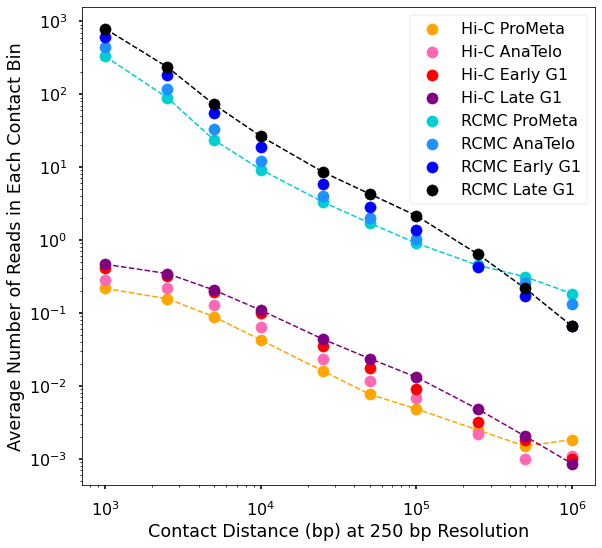

In [40]:
# Plot the average read counts across contact distances averaged across regions

import matplotlib.pyplot as plt

# print(plt.rcParams.get('figure.figsize')) DEFAULT FIGSIZE = 12.8, 8.8
plt.figure(figsize=(9.2, 8.8))

plt.plot(distances, clrRCMC_PM_counts, c = 'darkturquoise', linewidth=1.5, linestyle='dashed', zorder=0)
plt.plot(distances, clrRCMC_LG1_counts, c = 'black', linewidth=1.5, linestyle='dashed', zorder=0)
plt.plot(distances, clrHiC_PM_counts, c = 'orange', linewidth=1.5, linestyle='dashed', zorder=0)
plt.plot(distances, clrHiC_LG1_counts, c = 'purple', linewidth=1.5, linestyle='dashed', zorder=0)

plt.scatter(distances, clrHiC_PM_counts, c = 'orange', label='Hi-C ProMeta', zorder=1)
plt.scatter(distances, clrHiC_AT_counts, c = 'hotpink', label='Hi-C AnaTelo', zorder=1)
plt.scatter(distances, clrHiC_EG1_counts, c = 'red', label='Hi-C Early G1', zorder=1)
plt.scatter(distances, clrHiC_LG1_counts, c = 'purple', label='Hi-C Late G1', zorder=1)
plt.scatter(distances, clrRCMC_PM_counts, c = 'darkturquoise', label='RCMC ProMeta', zorder=1)
plt.scatter(distances, clrRCMC_AT_counts, c = 'dodgerblue', label='RCMC AnaTelo', zorder=1)
plt.scatter(distances, clrRCMC_EG1_counts, c = 'blue', label='RCMC Early G1', zorder=1)
plt.scatter(distances, clrRCMC_LG1_counts, c = 'black', label='RCMC Late G1', zorder=1)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Contact Distance (bp) at 250 bp Resolution")
plt.ylabel("Average Number of Reads in Each Contact Bin")
plt.legend()

plt.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200) # swap out .svg for the desired output file format
plt.show()